Loaded precession_0_500kyr_inter100, available keys: dict_keys(['__header__', '__version__', '__globals__', 'precession_0_500kyr_inter100'])
Loaded AICC2012_edc_d18O_stenni_2010, available keys: dict_keys(['__header__', '__version__', '__globals__', 'AICC2012_edc_d18O_stenni_2010'])
Loaded ngrip_modelex_b2k_inter50_Ras2014, available keys: dict_keys(['__header__', '__version__', '__globals__', 'ngrip_modelex_b2k_inter50_Ras2014'])


Text(0, 0.5, 'Frequency')

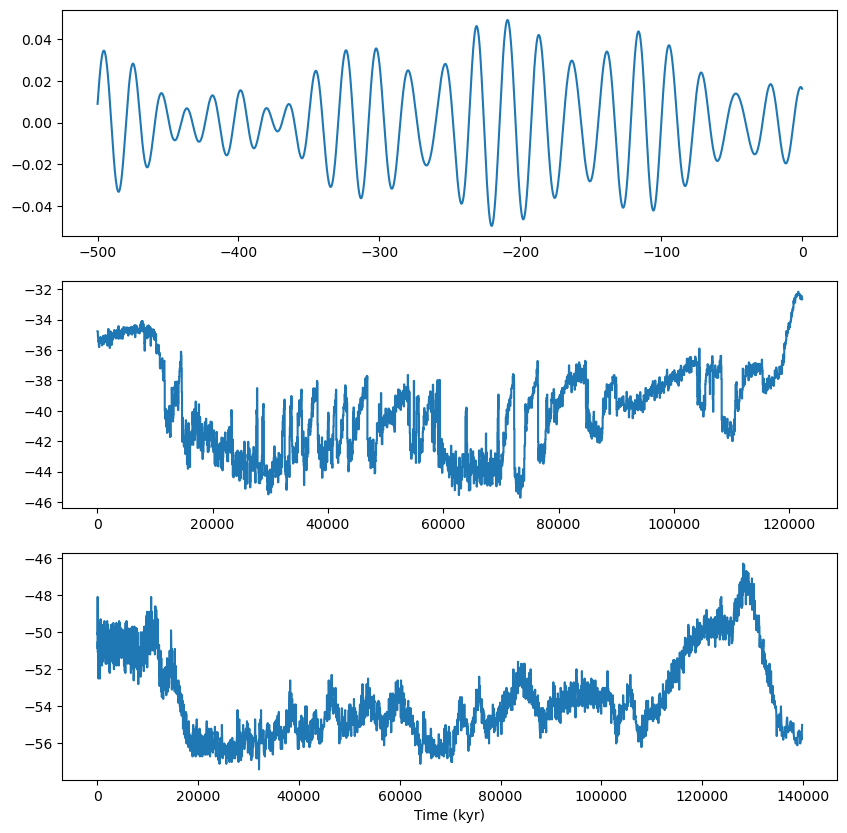

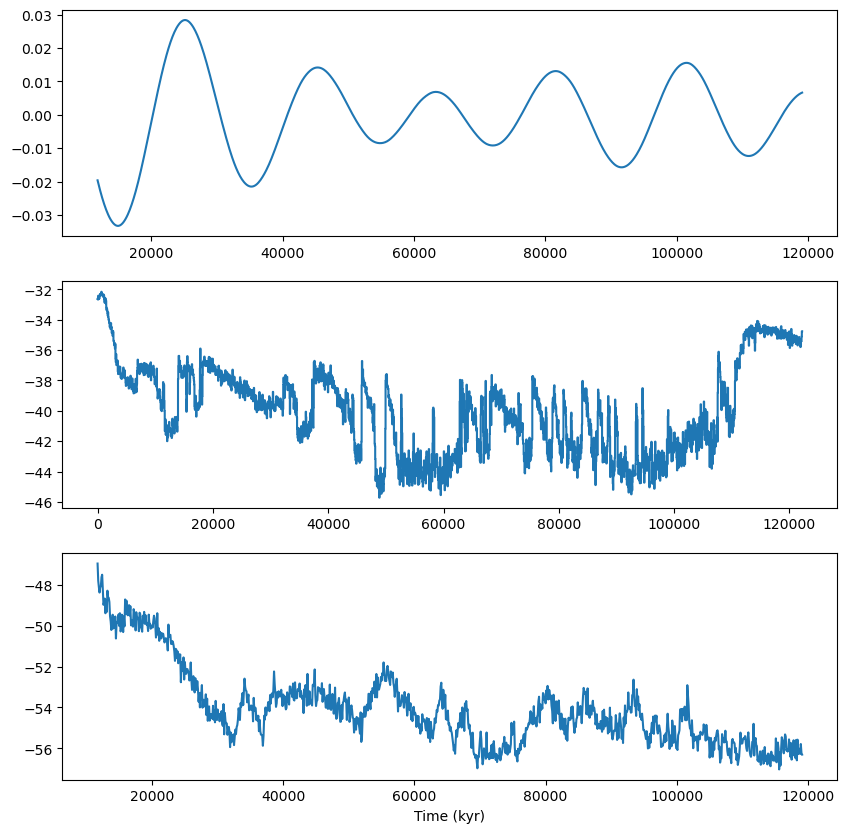

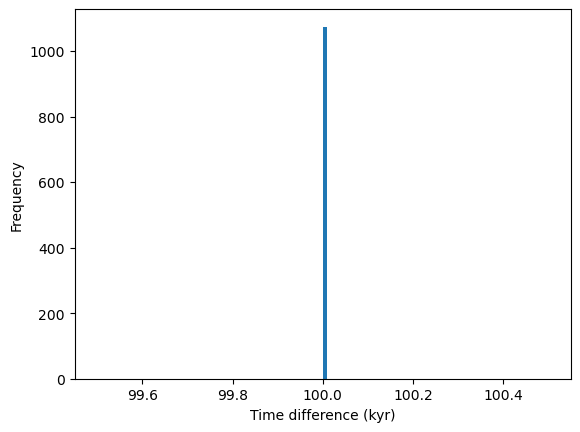

In [58]:
import scipy.io as sio
import os
import numpy as np

# Directory where your .mat files are stored
mat_dir = r"D:\VScode\bipolar_seesaw_CCM\Matlab_files"

# 1) Load precession_0_500kyr_inter100.mat
file1 = os.path.join(mat_dir, "precession_0_500kyr_inter100.mat")
mat_contents_file1 = sio.loadmat(file1)
precession_0_500kyr_inter100 = mat_contents_file1['precession_0_500kyr_inter100']
print("Loaded precession_0_500kyr_inter100, available keys:", mat_contents_file1.keys())

# 2) Load AICC2012_edc_d18O_stenni_2010.mat
file2 = os.path.join(mat_dir, "AICC2012_edc_d18O_stenni_2010.mat")
mat_contents_file2 = sio.loadmat(file2)
AICC2012_edc_d18O_stenni_2010 = mat_contents_file2['AICC2012_edc_d18O_stenni_2010']
print("Loaded AICC2012_edc_d18O_stenni_2010, available keys:", mat_contents_file2.keys())

# 3) Load ngrip_modelex_b2k_inter50_Ras2014.mat
file3 = os.path.join(mat_dir, "ngrip_modelex_b2k_inter50_Ras2014.mat")
mat_contents_file3 = sio.loadmat(file3)
ngrip_modelex_b2k_inter50_Ras2014 = mat_contents_file3['ngrip_modelex_b2k_inter50_Ras2014']
print("Loaded ngrip_modelex_b2k_inter50_Ras2014, available keys:", mat_contents_file3.keys())

pre = precession_0_500kyr_inter100
edc = AICC2012_edc_d18O_stenni_2010
ngrip = ngrip_modelex_b2k_inter50_Ras2014

# plot three datasets
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=False)
ax[0].plot(pre[:,0], pre[:,1], label='precession_0_500kyr_inter100')
ax[1].plot(ngrip[:,0], ngrip[:,1], label='ngrip_modelex_b2k_inter50_Ras2014')
ax[2].plot(edc[:,0], edc[:,1], label='AICC2012_edc_d18O_stenni_2010')

ax[2].set_xlabel('Time (kyr)')


pre[:,0] = pre[:,0] *- 1000
pre[:,0] = pre[:,0]*-1+max(pre[:,0])
ngrip[:,0] = ngrip[:,0] *-1+max(ngrip[:,0])
edc[:,0] = edc[:,0] *-1+max(edc[:,0])

# resample the edc data to 100 year resolution
from scipy.interpolate import interp1d
f = interp1d(edc[:,0], edc[:,1])
# create a new time vector
# edc_new_time =[i for i in range(int(np.ceil(min(edc[:,0]))), int(np.floor(max(edc[:,0]))), 100)]
# edc_new_time =11703:100 119140
edc_new_time = np.arange(11703, 119140, 100)
edc_new_data = f(edc_new_time)

edc = np.column_stack((edc_new_time, edc_new_data))

# crop pre between 11703 and 119140
pre = pre[pre[:,0] >= 11703]
pre = pre[pre[:,0] <= 119140]



fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=False)
ax[0].plot(pre[:,0], pre[:,1], label='precession_0_500kyr_inter100')
ax[1].plot(ngrip[:,0], ngrip[:,1], label='ngrip_modelex_b2k_inter50_Ras2014')
ax[2].plot(edc[:,0], edc[:,1], label='AICC2012_edc_d18O_stenni_2010')

ax[2].set_xlabel('Time (kyr)')

# plot a hist for diff(edc[:,0])
edc_diff = np.diff(edc[:,0])
plt.figure()
plt.hist(edc_diff, bins=100)
plt.xlabel('Time difference (kyr)')
plt.ylabel('Frequency')

In [50]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore

def bandpass_filter(edc, show=False, order=2):
    """
    Apply a band-pass filter to the 'pre' column of the edc time series.
    
    Parameters:
        edc (ndarray): 2D array with shape (5001,2). 
                       First column is age (with a step of 100 years), 
                       second column is the signal to filter.
        show (bool):   If True, plot the original and filtered signals.
        order (int):   Order of the Butterworth filter (default is 2).
        
    Returns:
        filtered_signal (ndarray): The filtered signal (1D array).
    """
    # Extract time and signal data
    time = edc[:, 0]
    signal = edc[:, 1]
    
    # Determine the sampling interval and sampling frequency
    dt = time[1] - time[0]   # should be 100 years
    fs = 1.0 / dt            # sampling frequency in samples/year
    nyq = fs / 2.0           # Nyquist frequency
    
    # Define the band (in terms of periods, then convert to frequencies)
    low_period = 25000.0     # years
    high_period = 15000.0    # years
    low_cut = 1.0 / low_period    # low cutoff frequency (cycles/year)
    high_cut = 1.0 / high_period  # high cutoff frequency (cycles/year)
    
    # Normalize cutoff frequencies by the Nyquist frequency
    low = low_cut / nyq
    high = high_cut / nyq
    
    # Design the Butterworth band-pass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Filter the signal using filtfilt for zero-phase filtering
    filtered_signal = filtfilt(b, a, signal)
    
    # Optionally plot the original and filtered signals for comparison
    if show:
        plt.figure(figsize=(10, 6))
        plt.plot(time, zscore(signal), label='Original', alpha=0.7)
        plt.plot(time, zscore(filtered_signal), label='Filtered', linewidth=2)
        plt.xlabel('Age (years)')
        plt.ylabel('Signal (normalized)')
        plt.title(f'Band-pass Filtering (Period {int(low_period)} - {int(high_period)} years)')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return filtered_signal


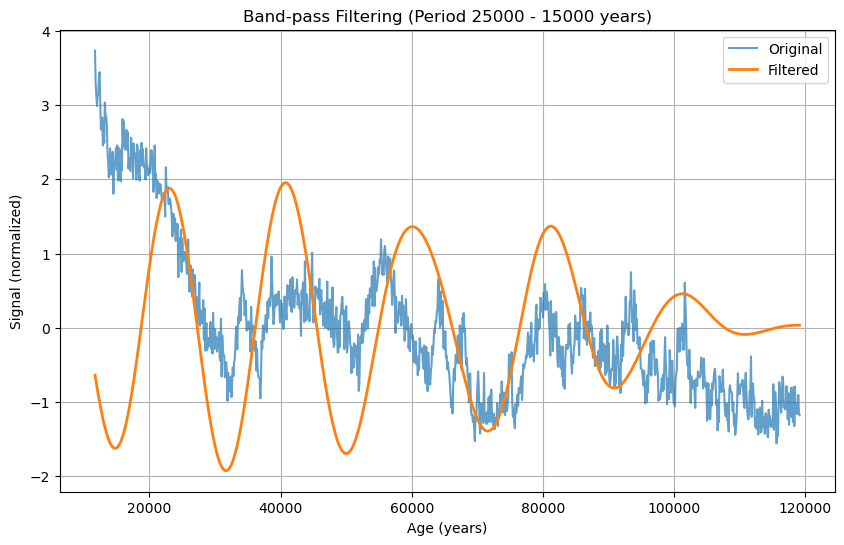

In [59]:
edc_pre=bandpass_filter(edc, show=True, order=2)

In [ ]:
data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6", "GS-7", "GS-8",
              "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14", "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2",
              "GS-17.1", "GS-17.2", "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    "end":   [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "start": [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}



# all start and end times should *-1 then +119140
data['start'] = [-1 * i + 119140 for i in data['start']]
data['end'] = [-1 * i + 119140 for i in data['end']]
data


{'event': ['GS-1',
  'GS-2.1c',
  'GS-2.2',
  'GS-3',
  'GS-4',
  'GS-5.1',
  'GS-5.2',
  'GS-6',
  'GS-7',
  'GS-8',
  'GS-9',
  'GS-10',
  'GS-11',
  'GS-12',
  'GS-13',
  'GS-14',
  'GS-15.1',
  'GS-15.2',
  'GS-16.1',
  'GS-16.2',
  'GS-17.1',
  'GS-17.2',
  'GS-18',
  'GS-19.1',
  'GS-19.2',
  'GS-20',
  'GS-21.1',
  'GS-21.2',
  'GS-22',
  'GS-23.1',
  'GS-23.2',
  'GS-24.1',
  'GS-24.2',
  'GS-25',
  'GS-26'],
 'end': [107437,
  104448,
  96120,
  95800,
  91360,
  90240,
  88300,
  86640,
  85400,
  83660,
  80920,
  78980,
  77680,
  75800,
  72280,
  69860,
  64920,
  64140,
  63340,
  61100,
  60860,
  60060,
  59700,
  55040,
  49520,
  46800,
  42700,
  34380,
  34080,
  29100,
  15100,
  14620,
  12390,
  10860,
  3770],
 'start': [106244,
  96240,
  95920,
  91600,
  90540,
  88540,
  87100,
  85780,
  84400,
  82560,
  79240,
  78340,
  76900,
  74860,
  70800,
  69540,
  64240,
  63740,
  62640,
  60980,
  60580,
  59840,
  55300,
  49740,
  48760,
  45040,
  41380,
  

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dummy_AT(data, w_slope=1.0, c_slope=1.0):
    """
    Generate a fictional time series from GS-event data with piecewise
    warming (rise) and cooling (fall) segments.
    
    Parameters
    ----------
    data : dict
        A dictionary with keys:
          - "event" : list of event names (e.g. ["GS-1", "GS-2.1c", ...])
          - "start" : list of start times (one per event)
          - "end"   : list of end times   (one per event)
        After your transformations, these might be reversed or in any order.
    w_slope : float
        Warming slope factor.  The total rise for each event i is
          w_slope * |end[i] - start[i]|.
    c_slope : float
        Cooling slope factor.  The total fall between event i's end 
        and event (i+1)'s start is
          c_slope * |start[i+1] - end[i]|.
          
    Returns
    -------
    T : 1D ndarray
        The array of time (in ascending order).
    Y : 1D ndarray
        The resulting fictional temperature (or similar) values.
    """
    
    # Extract arrays from the dictionary
    events_orig = data["event"]
    starts_orig = np.array(data["start"], dtype=float)
    ends_orig   = np.array(data["end"],   dtype=float)
    
    # Sort events by their start times in ascending order
    # (So the earliest time is first and we move forward through time)
    idx = np.argsort(starts_orig)
    events = [events_orig[i] for i in idx]
    starts = starts_orig[idx]
    ends   = ends_orig[idx]
    
    # We will build T and Y in segments.
    T = []
    Y = []
    
    # Initial condition: "the time series is set to zero" at the first event's start
    current_val = 0.0
    current_time = starts[0]
    
    T.append(current_time)
    Y.append(current_val)
    
    n_events = len(events)
    
    for i in range(n_events):
        # Warming segment from start[i] to end[i]
        st = starts[i]
        en = ends[i]
        
        # If st == en, no real "warm" segment to process
        if st == en:
            # Go directly to possible cooling (if there's a next event)
            pass
        else:
            # Warm amplitude = w_slope * |en - st|
            duration = en - st
            warm_ampl = w_slope * abs(duration)
            
            # Decide the direction of time
            if en > st:
                # normal ascending time
                ts_segment = np.linspace(st, en, num=int(abs(duration))+1)
            else:
                # if en < st, we still create ascending time from smaller->larger
                ts_segment = np.linspace(en, st, num=int(abs(duration))+1)
                # then we will flip it back below
                ts_segment = ts_segment[::-1]
            
            val_start = current_val
            val_end   = current_val + warm_ampl  # "rise"
            
            # Build the warm segment
            warm_vals = np.linspace(val_start, val_end, num=len(ts_segment))
            
            # Attach them to T, Y (excluding the very first point if we already have it to avoid duplication)
            if len(T) > 0 and np.isclose(ts_segment[0], T[-1]):
                T.extend(ts_segment[1:])
                Y.extend(warm_vals[1:])
            else:
                T.extend(ts_segment)
                Y.extend(warm_vals)
            
            current_val = Y[-1]
            current_time = T[-1]
        
        # Cooling segment from end[i] to start[i+1], except for the last event
        if i < n_events - 1:
            next_start = starts[i+1]
            # if en -> next_start is zero or negative duration, skip
            if en == next_start:
                continue
            else:
                # cooling amplitude
                duration_cool = next_start - en
                cool_ampl = c_slope * abs(duration_cool)
                
                # build time array from smaller->larger
                t_low  = min(en, next_start)
                t_high = max(en, next_start)
                ts_segment_cool = np.linspace(t_low, t_high, num=int(abs(duration_cool))+1)
                if next_start < en:
                    # if next_start < en, we want to keep T in ascending order
                    # so if en>next_start, that means times go backward.
                    # We'll flip the array after constructing it
                    ts_segment_cool = ts_segment_cool[::-1]
                
                # We want a linear drop of 'cool_ampl' from the current_val
                val_start_cool = current_val
                val_end_cool   = current_val - cool_ampl  # "cool down"
                
                cool_vals = np.linspace(val_start_cool, val_end_cool, num=len(ts_segment_cool))
                
                # Append
                # avoid duplicating the last time point from warming
                if len(T) > 0 and np.isclose(ts_segment_cool[0], T[-1]):
                    T.extend(ts_segment_cool[1:])
                    Y.extend(cool_vals[1:])
                else:
                    T.extend(ts_segment_cool)
                    Y.extend(cool_vals)
                
                current_val = Y[-1]
                current_time = T[-1]
    
    # Convert to arrays and ensure final ascending sort (in case any segments reversed)
    T = np.array(T)
    Y = np.array(Y)
    sort_idx = np.argsort(T)
    T = T[sort_idx]
    Y = Y[sort_idx]
    
    # Plot
    plt.figure(figsize=(9, 5))
    plt.plot(T, Y, label='Fictional Warming-Cooling TS')
    
    # Label each event near the midpoint of its warming segment
    for i in range(n_events):
        st = starts[i]
        en = ends[i]
        midpoint = 0.5*(st + en)
        # find nearest time index to that midpoint
        idx_mid = np.argmin(np.abs(T - midpoint))
        plt.text(T[idx_mid], Y[idx_mid], events[i], rotation=90,
                 verticalalignment='bottom', fontsize=8)
    
    plt.xlabel("Time (arbitrary units, ascending)")
    plt.ylabel("Fictional Value")
    plt.legend()
    plt.title("Fictional GS-Event Time Series")
    plt.tight_layout()
    plt.show()
    
    return T, Y


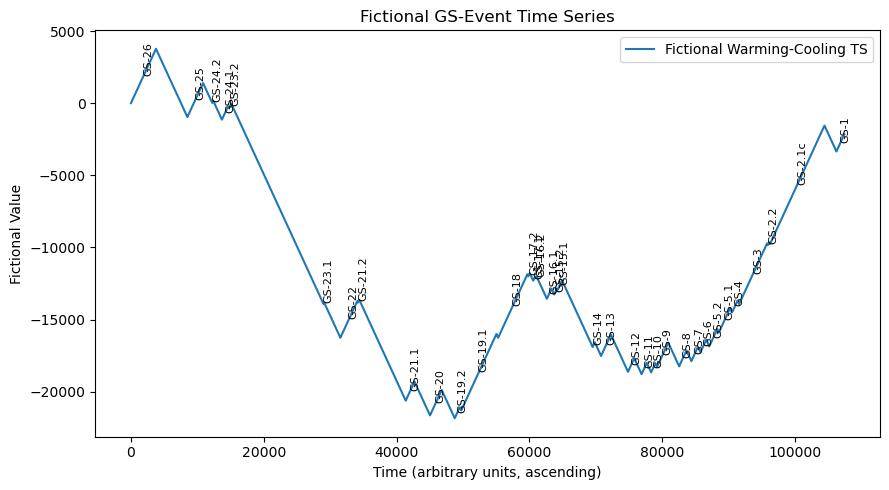

In [42]:
T,Y=generate_dummy_AT(data, w_slope=1, c_slope=1)
dummy_AT=np.column_stack((T,Y))

In [48]:
T

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.07435e+05,
       1.07436e+05, 1.07437e+05])

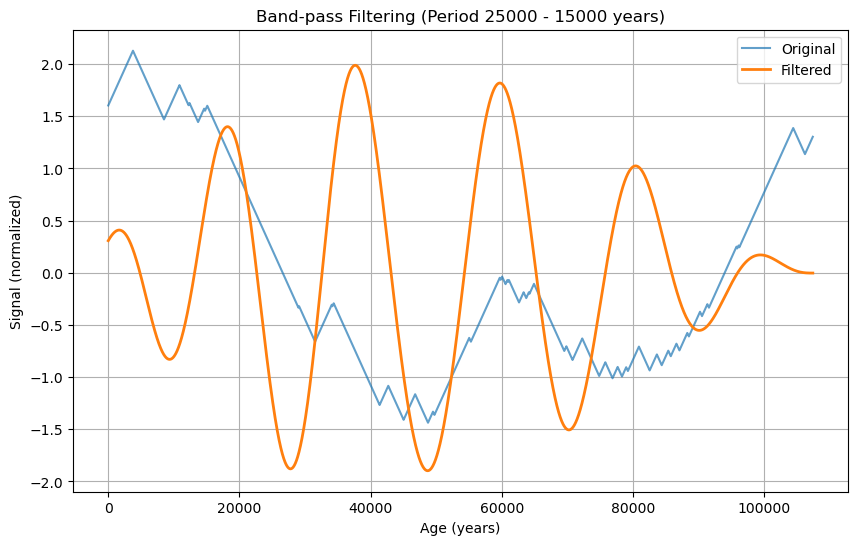

In [45]:
dummy_AT_pre=bandpass_filter(dummy_AT, show=True, order=2)

(<matplotlib.legend.Legend at 0x2d59c16ee80>, None)

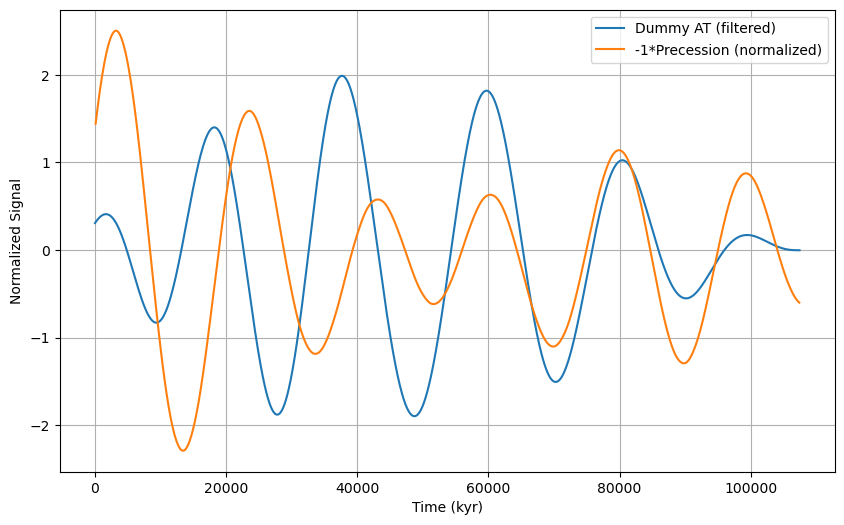

In [63]:
# plot edc_pre and dummy_AT_pre
plt.figure(figsize=(10, 6))
# plt.plot(edc[:,0]-11703, zscore(edc_pre), label='EDC (filtered)')
plt.plot(dummy_AT[:,0], zscore(dummy_AT_pre), label='Dummy AT (filtered)')
plt.plot(pre[:,0]-11703, zscore(pre[:,1])*-1, label='-1*Precession (normalized)')
plt.xlabel('Time (kyr)'), plt.ylabel('Normalized Signal')
plt.legend(), plt.grid(True)

In [ ]:
#

In [18]:
pre.shape

(5001, 2)

In [15]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

def fil_pre(data):
    """
    data must be two columns: (time, proxy).
    The bandpass is between [0.04, 0.06] freq, i.e. ~16.6 to 25 kyr period.
    """
    # Resample to 100-yr increments:
    t_min = np.ceil(data[0, 0])
    t_max = np.floor(data[-1, 0])
    t_new = np.arange(t_min, t_max+1, 100)
    f_proxy = interp1d(data[:, 0], data[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    data_new = np.column_stack([t_new, f_proxy(t_new)])

    # 1) Low-pass filter at 0.1 (with sampling freq=10 => i.e. cut=0.1/(10/2)=0.02 cyc/sample?), 
    #   but let's keep the MATLAB logic as-is:
    fs = 10.0
    b, a = butter(4, 0.1/(fs/2), btype='low')
    data_low = filtfilt(b, a, data_new[:, 1])
    data_low = np.column_stack([t_new, data_low])

    # 2) Now resample data_low at 1000 yr increments:
    t_1000 = np.arange(1000, np.floor(data_low[-1, 0]) + 1, 1000)
    f_low = interp1d(data_low[:, 0], data_low[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    data_low_1000 = np.column_stack([t_1000, f_low(t_1000)])

    # 3) Bandpass filter for freq = [0.04, 0.06], with Fs=1 (1 sample per 1000 yrs)
    freq = [0.04, 0.06]
    fs2 = 1.0
    b2, a2 = butter(4, [freq[0]/(fs2/2), freq[1]/(fs2/2)], btype='band')
    data_pre = filtfilt(b2, a2, data_low_1000[:, 1])
    data_pre = np.column_stack([t_1000, data_pre])
    return data_pre

In [16]:
fil_pre(pre)

array([[ 1.00000000e+03,  7.73452734e-04],
       [ 2.00000000e+03,  9.20910360e-03],
       [ 3.00000000e+03,  1.68391705e-02],
       [ 4.00000000e+03,  2.28602666e-02],
       [ 5.00000000e+03,  2.66288825e-02],
       [ 6.00000000e+03,  2.77322176e-02],
       [ 7.00000000e+03,  2.60344836e-02],
       [ 8.00000000e+03,  2.16933858e-02],
       [ 9.00000000e+03,  1.51448024e-02],
       [ 1.00000000e+04,  7.05724057e-03],
       [ 1.10000000e+04, -1.73897900e-03],
       [ 1.20000000e+04, -1.03400358e-02],
       [ 1.30000000e+04, -1.78647176e-02],
       [ 1.40000000e+04, -2.35477810e-02],
       [ 1.50000000e+04, -2.68203802e-02],
       [ 1.60000000e+04, -2.73688713e-02],
       [ 1.70000000e+04, -2.51657556e-02],
       [ 1.80000000e+04, -2.04696575e-02],
       [ 1.90000000e+04, -1.37946696e-02],
       [ 2.00000000e+04, -5.85276472e-03],
       [ 2.10000000e+04,  2.52412215e-03],
       [ 2.20000000e+04,  1.04736065e-02],
       [ 2.30000000e+04,  1.71941001e-02],
       [ 2.

Coherence near 23-kyr period:  0.9999999999999998
Phase (converted to time lag) near 23-kyr period:  -1.8291154173966893


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 108, using nperseg = 108
  warnings.warn('nperseg = {0:d} is greater than input length '


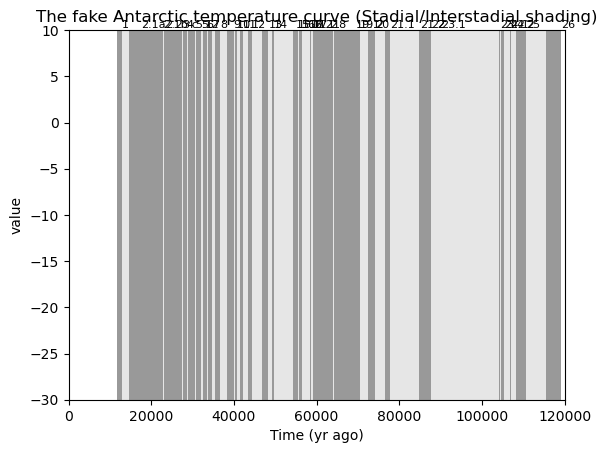

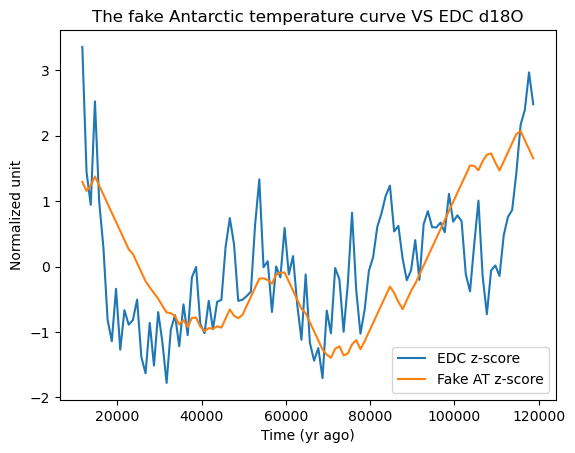

ValueError: The length of the input vector x must be greater than padlen, which is 27.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, coherence, csd


pre = precession_0_500kyr_inter100
edc = AICC2012_edc_d18O_stenni_2010
ngrip = ngrip_modelex_b2k_inter50_Ras2014

# --- 1. Manipulate 'pre': flip, convert time to kyr, resample at 1000 yr ---
pre = np.flipud(pre)  # flip rows up-down
pre[:, 0] = np.abs(pre[:, 0]) * 1000  # convert from kyr to yr, ensuring positive time

# create new time array
t_resamp = np.arange(1000, np.floor(pre[-1, 0]) + 1, 1000)

# Use interpolation to get data on 1000-yr spacing
f_pre = interp1d(pre[:, 0], pre[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
pre = np.column_stack((t_resamp, f_pre(t_resamp)))

# --- 2. EDC d18O (AICC2012) ---
# (Matlab code: edc = AICC2012_edc_d18O_stenni_2010; just rename in Python)
edc_or = edc.copy()  # keep original if needed

# --- 3. NGRIP d18O ---
# (Matlab code: ngrip = ngrip_modelex_b2k_inter50_Ras2014; and shift time by -50)
ngrip[:, 0] = ngrip[:, 0] - 50

# --- 4. Define timing arrays for Greenland warming/cooling transitions ---
G_wmp = np.array([
    11703, 14692, 17480, 23020, 23340, 27780, 28900, 30840, 32500, 33740,
    35480, 38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800,
    58040, 58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060,
    90040, 104040, 104520, 106750, 108280, 115370
])
G_cmp = np.array([
    12896, 17480, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740,
    36580, 39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500,
    58160, 58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600,
    90140, 104380, 105440, 106900, 110640, 119140
])
GS_label = [
    '1','2.1a','2.1b-c','2.2','3','4','5.1','5.2','6','7','8','9','10','11','12',
    '13','14','15.1','15.2','16.1','16.2','17.1','17.2','18','19.1','19.2','20',
    '21.1','21.2','22','23.1','23.2','24.1','24.2','25','26'
]

# Compute durations
gsd = G_cmp - G_wmp          # stadial durations
gid = G_wmp[1:] - G_cmp[:-1] # interstadial durations

# --- 5. Build a "fake Antarctic temperature curve" from DO transitions ---
k = 2
h = 1

# We'll store results in temp_lin for the linear version
temp_lin = []
temp_lin.append([G_cmp[-1], 0])  # Start: temp_lin(1,:) in MATLAB

# For convenience, define them as lists and append; we can convert to NumPy array at the end
temp_lin = np.array(temp_lin, dtype=float)
# We also show an "exp" approach in the code, but the user sets `lin_or_exp = 1`, so we’ll do linear.

lin_or_exp = 1  # 1 => linear, 0 => exponential

# define warming/cooling slopes
slope_w = 0.001 * np.ones_like(G_wmp)
slope_c = 0.001 * np.ones_like(G_wmp[:-1])  # one fewer for cooling segments

# We will build 'temp' as we go:
temp_list = [list(temp_lin[0])]  # initial row: [ G_cmp(end), 0 ]

# Because we index from the last DO event to the first (like the MATLAB code does i=length(G_cmp):-1:1)
k_idx = 1  # Python zero-based indexing for `temp_list`
h_idx = 0
for i in range(len(G_cmp)-1, -1, -1):
    if lin_or_exp == 1:
        # Some special condition in the MATLAB code:
        # if k==22||k==24||k==64||k==68 => slope_w=0. For clarity, we track them differently in Python
        # but we'll skip that special condition unless you truly need it:
        # ...
        # We'll just keep slope_w=0.001 for each, unless you want to replicate that condition exactly.

        # From the code:
        # 'temp_lin(k,:) = [G_wmp(i), temp_lin(k-1,2)+gsd(i)*slope_w(h,1)]'
        prev_val = temp_list[k_idx-1][1]
        new_time = G_wmp[i]
        new_val  = prev_val + gsd[i] * slope_w[h_idx]
        temp_list.append([new_time, new_val])
        k_idx += 1

        # plot statements in MATLAB go here, but we will do all plotting later
        # text statements, etc.

        # next chunk if i>=2 => i>=1 in 1-based indexing
        if i >= 1:
            prev_val_2 = temp_list[k_idx-1][1]
            new_time_2 = G_cmp[i-1]
            # 'temp_lin(k,:) = [G_cmp(i-1), temp_lin(k-1,2)-gid(i-1)*slope_c(h,1)]'
            new_val_2  = prev_val_2 - gid[i-1] * slope_c[h_idx]
            temp_list.append([new_time_2, new_val_2])
            k_idx += 1
            h_idx += 1

    else:
        # If lin_or_exp == 0 => exponential version
        # we skip it, or replicate the code if needed
        pass

# Convert temp_list to NumPy array and flip it (like final step in MATLAB)
temp = np.array(temp_list, dtype=float)
temp = temp[np.argsort(temp[:, 0])]  # sort by time ascending
# In MATLAB, they do "temp=flipud(temp);" then "temp=[0,temp(1,2);temp];"
# so we replicate that exactly:
temp = np.flipud(temp)
first_time_val = [0, temp[0, 1]]
temp = np.vstack([first_time_val, temp])

# Remove duplicates in the 'temp' time column
_, idx_unique = np.unique(temp[:, 0], return_index=True)
temp = temp[np.sort(idx_unique)]

###############################################################################
# Now replicate the quick "compare with edc" step:
###############################################################################
in_of_in = [11703, 119140]
t_interest = np.arange(in_of_in[0], in_of_in[1] + 1, 1000, dtype=float)

# Interpolate edc onto t_interest
f_edc = interp1d(edc[:, 0], edc[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
x_edc = np.column_stack((t_interest, f_edc(t_interest)))

# Interpolate temp onto t_interest
f_temp = interp1d(temp[:, 0], temp[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
x_temp = np.column_stack((t_interest, f_temp(t_interest)))

# Example: compute coherence and phase between EDC and this "fake" AT
# (mscohere => scipy.signal.coherence, cpsd => scipy.signal.csd)
fs = 1.0  # 1 sample per "time unit" of 1 year? (Be consistent with your times)
f, Cxy = coherence(x_edc[:, 1], x_temp[:, 1], fs=fs, nperseg=None)
f2, Pxy = csd(x_edc[:, 1], x_temp[:, 1], fs=fs, nperseg=None)

# Example: get phase in radians => convert to degrees or fraction of cycle
phase = np.angle(Pxy)

# We can pick out frequency near 1/23 = 0.043...
freq_23 = 1/23
# Find the index of freq closest to freq_23
idx_23 = np.argmin(np.abs(f - freq_23))
cw_lag = (phase[idx_23] / (2 * np.pi)) * 23  # approximate "lag" in years
cw_cohe = Cxy[idx_23]

print("Coherence near 23-kyr period: ", cw_cohe)
print("Phase (converted to time lag) near 23-kyr period: ", cw_lag)

###############################################################################
# PLOTTING
# Below is a condensed version of the multi-figure approach. 
# We replicate the major elements; you can refine layout as desired.
###############################################################################

# Figure 1: Show stadial vs interstadial shading and the labeling
plt.figure()
ax1 = plt.gca()
ax1.set_xlim([0, 120000])
ax1.set_ylim([-30, 10])
for i in range(len(G_cmp)):
    width = G_cmp[i] - G_wmp[i]
    # Gray rectangle for the stadial:
    ax1.add_patch(
        plt.Rectangle(
            (G_wmp[i], -30),
            width,
            40,  # from -30 to +10 => height=40
            facecolor=(0.6, 0.6, 0.6),
            edgecolor=None
        )
    )
    if i < len(G_cmp) - 1:
        # Next rectangle is from [G_cmp(i), G_wmp(i+1)], slightly lighter
        width2 = G_wmp[i+1] - G_cmp[i]
        ax1.add_patch(
            plt.Rectangle(
                (G_cmp[i], -30),
                width2,
                40,
                facecolor=(0.9, 0.9, 0.9),
                edgecolor=None
            )
        )
    # label at G_cmp[i]
    ax1.text(G_cmp[i], 10, GS_label[i], fontsize=8, verticalalignment='bottom')

plt.xlabel('Time (yr ago)')
plt.ylabel('value')
plt.title('The fake Antarctic temperature curve (Stadial/Interstadial shading)')

# Over-plot the lines (in MATLAB code we see they plot transitions, etc.)
# For brevity, skip replicating every red/blue line from the loops; you can do so similarly.

plt.show()

###############################################################################
# Example comparison of EDC vs. fake record
###############################################################################
plt.figure()
plt.plot(x_edc[:, 0], (x_edc[:, 1] - np.mean(x_edc[:, 1])) / np.std(x_edc[:, 1]), label='EDC z-score')
plt.plot(x_temp[:, 0], (x_temp[:, 1] - np.mean(x_temp[:, 1])) / np.std(x_temp[:, 1]), label='Fake AT z-score')
plt.xlabel('Time (yr ago)')
plt.ylabel('Normalized unit')
plt.title('The fake Antarctic temperature curve VS EDC d18O')
plt.legend()
plt.show()

###############################################################################
# Lomb-Scargle Periodogram (MATLAB 'plomb')
###############################################################################
# For a direct approach with significance levels, see astropy:
#
# from astropy.timeseries import LombScargle
# freq_ls = np.linspace(0.0, 0.3, 1000)
# ls = LombScargle(x_edc[:, 0]/1000, x_edc[:, 1]) # time in kyr
# power = ls.power(freq_ls)
# fap = ls.false_alarm_level(0.05)  # 5% significance, etc.
#
# Plot as in MATLAB:
# plt.plot(freq_ls, power)
# plt.axhline(fap, color='r', linestyle='--')
# etc.
#
###############################################################################

###############################################################################
# Finally, define the bandpass function to replicate fil_pre
###############################################################################



###############################################################################
# Example of using fil_pre on the main data:
###############################################################################
temp_pre = fil_pre(temp)
edc_pre = fil_pre(edc)

# Compare with precession curve:
# In MATLAB you see a final figure with subplots, etc. We'll just show 
# a quick example:
plt.figure()
plt.plot(edc_pre[:, 0], (edc_pre[:, 1] - np.mean(edc_pre[:, 1])) / np.std(edc_pre[:, 1]), label='EDC pre-filtered')
plt.plot(temp_pre[:, 0], (temp_pre[:, 1] - np.mean(temp_pre[:, 1])) / np.std(temp_pre[:, 1]), label='Fake AT pre-filtered')
plt.plot(pre[:, 0], -(pre[:, 1] - np.mean(pre[:, 1])) / np.std(pre[:, 1]), '--', label='-1 * precession')
plt.xlim([0, 120000])
plt.xlabel('Age (yr BP)')
plt.ylabel('Normalized unit')
plt.legend()
plt.title('Precession-band signal comparison')
plt.show()


In [8]:
temp.shape

(72, 2)